# 降圧型 DC-DC コンバータの RNN を使ったシミュレータ実験

$$i_L(t + \Delta t) = i_L(t) + \frac{\Delta t}{L} (v_a - v_o)$$

$$v_C(t + \Delta t) = v_C(t) + \frac{\Delta t}{C_o} \left( i_L - \frac{v_o}{R_o} \right)$$

1. DC-DC コンバータの波形を仮で作成
2. ノイズを乗せる
3. 学習モデルを作成し、回路パラメータの推論を行う


In [1]:
# 各種のインポート

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [2]:
# ============================
# 1. データ読み込み
# `../data/buck_converter_steady.csv` は、
# `notebooks/generate_buck_data.ipynb` で作成した理想的な定常状態のデータ
# ============================
df = pd.read_csv("../data/buck_converter_steady.csv")

# 入力: v_a(t)
# 出力: i_L(t+1), v_C(t+1)
va = torch.tensor(df["v_a_V"].values[:-1], dtype=torch.float32).unsqueeze(1)
iL = torch.tensor(df["i_L_A"].values, dtype=torch.float32)
vC = torch.tensor(df["v_C_V"].values, dtype=torch.float32)

# 状態ベクトル
h_seq = torch.stack([iL[:-1], vC[:-1]], dim=1)  # 現在の状態
h_target = torch.stack([iL[1:], vC[1:]], dim=1)  # 次時刻の状態

# シーケンスの長さ
N = len(va)
print(f"Loaded {N} samples from CSV")


Loaded 500 samples from CSV


Epoch 0: Loss=4.519785e-04  L=-8.00e-04  C=1.10e-03  R=8.001
Epoch 200: Loss=1.841715e-03  L=-9.41e-03  C=5.22e-03  R=8.007
Epoch 400: Loss=1.833166e-03  L=-1.21e-02  C=2.30e-03  R=8.009
Epoch 600: Loss=1.828306e-03  L=-1.44e-02  C=-1.87e-02  R=8.025
Epoch 800: Loss=1.825040e-03  L=-1.66e-02  C=-1.88e-02  R=8.025
Epoch 1000: Loss=1.822680e-03  L=-1.85e-02  C=-1.89e-02  R=8.026
Epoch 1200: Loss=1.820871e-03  L=-2.04e-02  C=-1.91e-02  R=8.026
Epoch 1400: Loss=1.819423e-03  L=-2.23e-02  C=-1.92e-02  R=8.026
Epoch 1600: Loss=1.818228e-03  L=-2.40e-02  C=-1.94e-02  R=8.026
Epoch 1800: Loss=1.817216e-03  L=-2.58e-02  C=-1.96e-02  R=8.026

=== Learned Parameters ===
L = -2.745e-02 H
C = -1.981e-02 F
R = 8.027 Ω


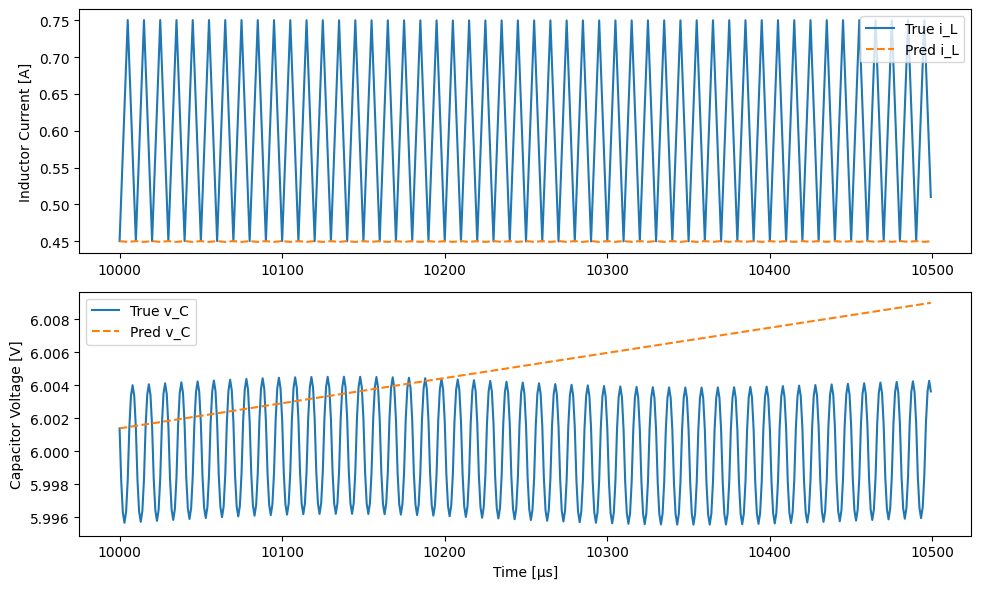

In [3]:
# ============================
# 2. BuckConverterCell 定義
# ============================
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt
        self.L = nn.Parameter(torch.tensor(L_init))
        self.C = nn.Parameter(torch.tensor(C_init))
        self.R = nn.Parameter(torch.tensor(R_init))

    def forward(self, h: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        i_L, v_C = h[:, 0], h[:, 1]
        v_a = x[:, 0]
        di = (self.dt / self.L) * (v_a - v_C)
        dv = (self.dt / self.C) * (i_L - v_C / self.R)
        i_L_next = i_L + di
        v_C_next = v_C + dv
        return torch.stack([i_L_next, v_C_next], dim=1)


# ============================
# 3. モデルと最適化設定
# ============================
model = BuckConverterCell(dt=1e-6)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

param_history = {"L": [], "C": [], "R": []}

# ============================
# 4. 学習ループ
# ============================
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred = model(h_seq, va)
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()


    param_history["L"].append(model.L.item())
    param_history["C"].append(model.C.item())
    param_history["R"].append(model.R.item())

    if epoch % 200 == 0:
        L_val = model.L.item()
        C_val = model.C.item()
        R_val = model.R.item()
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  L={L_val:.2e}  "
            f"C={C_val:.2e}  R={R_val:.3f}"
        )

# ============================
# 5. 学習後のパラメータ
# ============================
print("\n=== Learned Parameters ===")
print(f"L = {model.L.item():.3e} H")
print(f"C = {model.C.item():.3e} F")
print(f"R = {model.R.item():.3f} Ω")

# ============================
# 6. シミュレーション（再現波形生成）
# ============================
with torch.no_grad():
    h_sim = [h_seq[0].unsqueeze(0)]
    for t in range(1, N):
        h_next = model(h_sim[-1], va[t - 1].unsqueeze(0))
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

iL_sim = h_sim[:, 0].numpy()
vC_sim = h_sim[:, 1].numpy()

# ============================
# 7. 波形比較プロット
# ============================
time = df["time_s"].values[:-1] * 1e6  # μs単位
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, iL[:-1], label="True i_L")
plt.plot(time, iL_sim, "--", label="Pred i_L")
plt.legend()
plt.ylabel("Inductor Current [A]")

plt.subplot(2, 1, 2)
plt.plot(time, vC[:-1], label="True v_C")
plt.plot(time, vC_sim, "--", label="Pred v_C")
plt.legend()
plt.ylabel("Capacitor Voltage [V]")
plt.xlabel("Time [µs]")
plt.tight_layout()
plt.show()

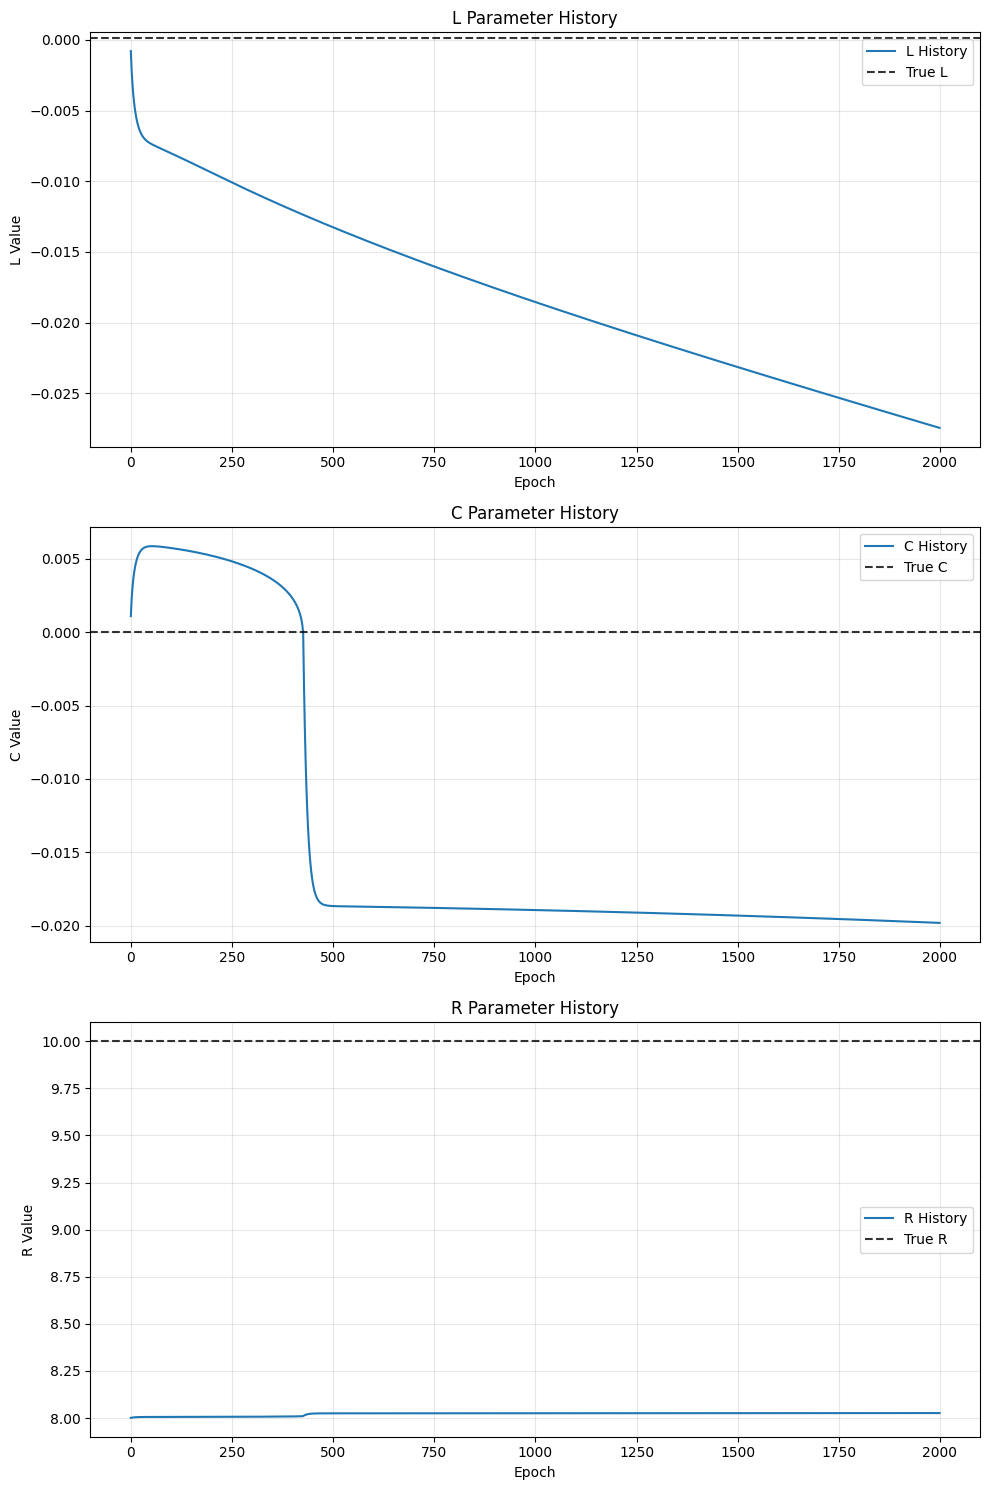

In [4]:
true_L = 100e-6  # インダクタ [H]
true_C = 47e-6  # コンデンサ [F]
true_R = 10.0  # 負荷抵抗 [Ω]


plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=true_L, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=true_C, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=true_R, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# まとめ
- 全然ダメ
- 精度が悪すぎる
- 元のPANNのコードとの主な違い
  - PANNモデルを定義してその中でEulerCell_Buckを呼び出している。このコードでは、BuckConverterCellを直接呼び出している。
  - idxを使っていない
  - iLにReLUを噛ませていない